# Subanalyses
In this notebook we analyse specific populations in more detail.

In [1]:
from matplotlib import pyplot as plt
from pandas import read_csv
from scipy.stats import fisher_exact
from sklearn.model_selection import LeaveOneOut, cross_val_predict
from sklearn.metrics import RocCurveDisplay, roc_auc_score

from statkit.distributions import ZeroInflatedExponential
from statkit.naive_bayes import NaiveBayesClassifier
from statkit.non_parametric import bootstrap_score, unpaired_permutation_test
from statkit.views import format_p_value

In [2]:
# Add end-to-end package to path.
import sys
from pathlib import Path

sys.path.append(str(Path('../').absolute()))

In [3]:
from src.statistics import hazard_ratio_test
from utils import X_y, plot_kaplan_meier, stratify_survival

Load signatures of discovery and validation set.

In [4]:
# Discovery dataset.
hrtw_signatures = read_csv('../artifacts/hartwig_wes_signature.tsv', sep='\t', index_col=0)
X_hrtw, y_hrtw = X_y(hrtw_signatures)
not_na_hrtw = (~y_hrtw.isna())

# Validation dataset.
miao = read_csv('../artifacts/miao_wes_signature.tsv', sep='\t', index_col=0)
X_miao, y_miao = X_y(miao)
not_na_miao = ~y_miao.isna()

We take the classification threshold as the number of durable benefit patients from another paper:
Donker et al., Lung Cancer ('22)

In [5]:
threshold = 160/365

In [6]:
features = ['SBS4', 'SBS87']
clf = NaiveBayesClassifier(ZeroInflatedExponential)


y_hrtw_proba = cross_val_predict(
    clf,
    X_hrtw.loc[not_na_hrtw, features],
    y_hrtw[not_na_hrtw],
    cv=LeaveOneOut(),
    method='predict_proba',
    verbose=1,
)[:, 1]

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  93 out of  93 | elapsed:    0.2s finished


In [7]:
# Train classifier on Hartwig data.
clf.fit(X_hrtw.loc[not_na_hrtw, features], y_hrtw[not_na_hrtw])
y_miao_proba = clf.predict_proba(X_miao[features]).iloc[:,1]
y_miao_pred = (y_miao_proba >= threshold).astype(int)

## Treatment naive group
To determine if we can improve the model, we select the top 10 worst false negatives.

In [8]:
top_fn = (y_hrtw[not_na_hrtw] - y_hrtw_proba).sort_values(ascending=False).iloc[:10]

Test if the top 10 false negatives is enriched in treatment naive patients.

In [9]:
is_naive =  X_hrtw['Treatment naive'] == 'Yes'
X_hrtw_naive = X_hrtw[is_naive]
X_hrtw_treated = X_hrtw[~is_naive]

n_naive_fn = len(X_hrtw_naive.loc[X_hrtw_naive.index.isin(top_fn.index)])
n_treated_fn = len(X_hrtw_treated.loc[X_hrtw_treated.index.isin(top_fn.index)])
n_naive_not_fn = len(X_hrtw_naive.loc[~X_hrtw_naive.index.isin(top_fn.index)])
n_treated_not_fn = len(X_hrtw_treated.loc[~X_hrtw_treated.index.isin(top_fn.index)])

# Must add up to all data.
assert n_naive_fn + n_treated_fn + n_naive_not_fn + n_treated_not_fn == len(X_hrtw)
treatment_table = [
    # In false negatives.
    [n_naive_fn, n_treated_fn],
    # Not in false negatives.
    [n_naive_not_fn, n_treated_not_fn],
]

odds, p_value = fisher_exact(treatment_table, alternative='two-sided')

print('Significant overrepresentation treatment naive patients in top 10 false negatives')
print('p =', format_p_value(p_value, format='compact'), 'Fisher exact test')

Significant overrepresentation treatment naive patients in top 10 false negatives
p = $0.015$ Fisher exact test


One potential way to improve, would be to exclude the treatment naive group.
Retrain and predict on samples without the treatment naive patients in the discovery cohort.

In [10]:
X_hrtw_pre = X_hrtw.loc[not_na_hrtw & (~is_naive)]
y_hrtw_pre = y_hrtw[not_na_hrtw & (~is_naive)]
y_hrtw_proba_pre = cross_val_predict(
    NaiveBayesClassifier(ZeroInflatedExponential),
    X_hrtw_pre[features],
    y_hrtw_pre,
    cv=LeaveOneOut(),
    method='predict_proba',
    verbose=1,
)[:, 1]

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  78 out of  78 | elapsed:    0.1s finished


In [11]:
# Original performance.
roc_auc_hrtw_all = bootstrap_score(y_hrtw[not_na_hrtw], y_hrtw_proba, metric=roc_auc_score)
# Performance of the model on pre-treated patients.
roc_auc_hrtw_pre = bootstrap_score(y_hrtw_pre, y_hrtw_proba_pre, metric=roc_auc_score)

print('ROC AUC discovery all patients', roc_auc_hrtw_all)
print('ROC AUC discovery without treatment naive patients', roc_auc_hrtw_pre)
print(roc_auc_hrtw_pre.latex())

ROC AUC discovery all patients 0.74 (95 % CI: 0.63-0.84)
ROC AUC discovery without treatment naive patients 0.79 (95 % CI: 0.68-0.90)
0.79$^{+0.11}_{-0.11}$


In [12]:
clf_pre = NaiveBayesClassifier(ZeroInflatedExponential)
clf_pre.fit(X_hrtw_pre[features], y_hrtw_pre)
y_miao_proba_pre = clf_pre.predict_proba(X_miao[features]).iloc[:,1]

In [13]:
roc_auc_miao_all = bootstrap_score(y_miao[not_na_miao], y_miao_proba[not_na_miao], metric=roc_auc_score)
roc_auc_miao_pre_clf = bootstrap_score(y_miao[not_na_miao], y_miao_proba_pre[not_na_miao], metric=roc_auc_score)
print('ROC AUC validation set trained on all discovery patients', roc_auc_miao_all)
print(roc_auc_miao_all.latex())
print('ROC AUC validation set trained on discovery set without treatment naive patients', roc_auc_miao_pre_clf)
print(roc_auc_miao_pre_clf.latex())

ROC AUC validation set trained on all discovery patients 0.69 (95 % CI: 0.53-0.83)
0.69$^{+0.14}_{-0.15}$
ROC AUC validation set trained on discovery set without treatment naive patients 0.71 (95 % CI: 0.57-0.84)
0.71$^{+0.13}_{-0.14}$


How well does the model perform on the discovery and validation dataset when we train only on the treatment naive group?

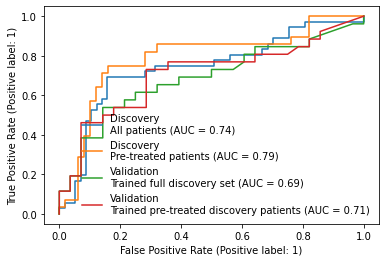

In [14]:
f = plt.figure()
ax = f.gca()
RocCurveDisplay.from_predictions(y_hrtw[not_na_hrtw], y_hrtw_proba, name='Discovery\nAll patients', ax=ax)
RocCurveDisplay.from_predictions(y_hrtw_pre, y_hrtw_proba_pre, name='Discovery\nPre-treated patients', ax=ax)
RocCurveDisplay.from_predictions(y_miao[not_na_miao], y_miao_proba[not_na_miao], name='Validation\nTrained full discovery set', ax=ax)
RocCurveDisplay.from_predictions(y_miao[not_na_miao], y_miao_proba_pre[not_na_miao], name='Validation\nTrained pre-treated discovery patients', ax=ax)
plt.legend(frameon=False)
plt.savefig('figs/roc-pretreatment-subanalysis.png')
plt.savefig('figs/roc-pretreatment-subanalysis.eps')
plt.savefig('figs/roc-pretreatment-subanalysis.svg')
plt.savefig('figs/roc-pretreatment-subanalysis.pdf')

## Non-smokers in validation set
The classifier relies on the smoking signature. We therefore set out to determine how well the model performs on the non-smokers.

In [15]:
pfs_miao = stratify_survival(y_miao_pred.astype(bool), X_miao['pfs_weeks'], X_miao['pfs_event'])

/tmp/ipykernel_14481/2574664633.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  hr_miao_smokers = plot_kaplan_meier(pfs_miao[~non_smoker], labels=['Signatures -', 'Signatures +'])


Median survival Signatures - : 17.857142857142858
Median survival Signatures + : inf
Hazard ratio $h_r=0.15^{+0.26}_{-0.09}$ ($p = 2.0 \cdot 10^{-4}$)


/tmp/ipykernel_14481/2574664633.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  hr_miao_never_smokers = plot_kaplan_meier(pfs_miao[non_smoker], labels=['Signatures -', 'Signatures +'])


Median survival Signatures - : 8.142857142857142
Median survival Signatures + : 8.0
Hazard ratio $h_r=1.4^{+5.2}_{-1.1}$ ($p = 0.70$)


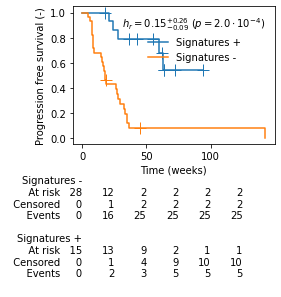

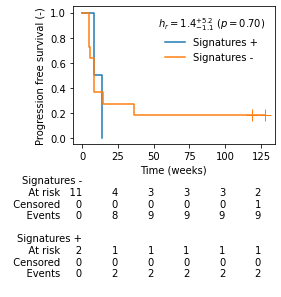

In [16]:
non_smoker = X_miao['smoker'] == 'never'
hr_miao_smokers = plot_kaplan_meier(pfs_miao[~non_smoker], labels=['Signatures -', 'Signatures +'])
hr_miao_never_smokers = plot_kaplan_meier(pfs_miao[non_smoker], labels=['Signatures -', 'Signatures +'])

First, how many patients do we consider in this subanalysis?

In [17]:
print('Number of patients in ROC AUC subanalysis: m =', len(y_miao[not_na_miao]))

Number of patients in ROC AUC subanalysis: m = 54


In [18]:
auc_never_smoker = bootstrap_score(y_miao[not_na_miao & non_smoker], y_miao_pred[not_na_miao & non_smoker], roc_auc_score)
print(auc_never_smoker.latex())

0.40$^{+0.10}_{-0.13}$


In [19]:
auc_smoker = bootstrap_score(y_miao[not_na_miao & (~non_smoker)], y_miao_pred[not_na_miao & (~non_smoker)], roc_auc_score)
print(auc_smoker.latex())

0.71$^{+0.12}_{-0.13}$


In [20]:
p_value = unpaired_permutation_test(
    y_miao[not_na_miao & non_smoker],
    y_miao_pred[not_na_miao & non_smoker], 
    y_miao[not_na_miao & (~non_smoker)], 
    y_miao_pred[not_na_miao & (~non_smoker)], 
    metric=roc_auc_score,
)
print('ROC AUC, significantly different: p =', format_p_value(p_value, format='compact'), 'UPT')

ROC AUC, significantly different: p = $0.033$ UPT


In [21]:
n_non_smoker = len(y_miao[not_na_miao & non_smoker])
n_non_smoker_benefit = y_miao[not_na_miao & non_smoker].sum().astype(int)
print(f'Number of durable benefit {n_non_smoker_benefit}/{n_non_smoker} out of non-smokers')

Number of durable benefit 3/13 out of non-smokers


So the predictions on the smoking group were significantly worse, although only three patients were in the positive class.